In [1]:
# Imports
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from config import *
from data_preprocessing import load_and_prepare_data, split_by_timestamp
from utils import (
    set_seeds,
    scale_numeric_features,
    create_sequences,
    to_python_types
)
from models import NinjaOptimizationAlgorithm, create_lstm_model
from train import objective_function_lstm
from evaluate import evaluate_model

# GPU Safety
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

set_seeds(RANDOM_SEED)
sns.set(style="whitegrid")


In [2]:
HORIZONS = [60, 300, 900]


In [3]:
#Canonical Split (k = 60)
base_k = 60
print(f"\n=== Initialising canonical split (k={base_k}) ===")

df = load_and_prepare_data(DATA_PATH, k=base_k)

t_train_end = df["server_timestamp"].quantile(TRAIN_RATIO)
t_val_end = df["server_timestamp"].quantile(TRAIN_RATIO + VAL_RATIO)

train_df, val_df, test_df = split_by_timestamp(df, t_train_end, t_val_end)

TARGET = "energy_delta_k"

feature_cols = [
    c for c in train_df.columns
    if c not in ["server_timestamp", "energy", TARGET]
]

X_train, y_train = train_df[feature_cols], train_df[TARGET]
X_val, y_val = val_df[feature_cols], val_df[TARGET]
X_test, y_test = test_df[feature_cols], test_df[TARGET]

X_train, X_val, X_test, scaler = scale_numeric_features(
    X_train, X_val, X_test, feature_cols
)

X_train_seq, y_train_seq = create_sequences(
    X_train.values, y_train.values, SEQUENCE_LENGTH
)
X_val_seq, y_val_seq = create_sequences(
    X_val.values, y_val.values, SEQUENCE_LENGTH
)
X_test_seq, y_test_seq = create_sequences(
    X_test.values, y_test.values, SEQUENCE_LENGTH
)

seq_len = X_train_seq.shape[1]
num_feats = X_train_seq.shape[2]



=== Initialising canonical split (k=60) ===


C:\Users\AnweshaSingh\anaconda_projects\IEEE_CEP_V5_5-15\utils.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[feature_cols] = scaler.transform(train[feature_cols])
C:\Users\AnweshaSingh\anaconda_projects\IEEE_CEP_V5_5-15\utils.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val[feature_cols] = scaler.transform(val[feature_cols])
C:\Users\AnweshaSingh\anaconda_projects\IEEE_CEP_V5_5-15\utils.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [4]:
#Save Canonical Splits
splits_dir = os.path.join(RESULTS_DIR, "splits")
os.makedirs(splits_dir, exist_ok=True)

np.save(f"{splits_dir}/X_train.npy", X_train_seq)
np.save(f"{splits_dir}/X_val.npy", X_val_seq)
np.save(f"{splits_dir}/X_test.npy", X_test_seq)

np.save(f"{splits_dir}/y_train_k60.npy", y_train_seq)
np.save(f"{splits_dir}/y_val_k60.npy", y_val_seq)
np.save(f"{splits_dir}/y_test_k60.npy", y_test_seq)

print("Canonical splits saved.")


Canonical splits saved.


In [5]:
#Multi-Horizon Training Loop
for k in HORIZONS:
    print(f"\n=== Running NiOA + DRNN for k={k} ===")

    horizon_dir = os.path.join(RESULTS_DIR, f"horizon_{k}")
    os.makedirs(horizon_dir, exist_ok=True)
    os.makedirs(f"{horizon_dir}/model", exist_ok=True)
    os.makedirs(f"{horizon_dir}/predictions", exist_ok=True)

    X_train_seq = np.load(f"{splits_dir}/X_train.npy")
    X_val_seq = np.load(f"{splits_dir}/X_val.npy")
    X_test_seq = np.load(f"{splits_dir}/X_test.npy")

    if k == 60:
        y_train_seq_k = y_train_seq
        y_val_seq_k = y_val_seq
        y_test_seq_k = y_test_seq
    else:
        df_k = load_and_prepare_data(DATA_PATH, k=k)
        train_df, val_df, test_df = split_by_timestamp(
            df_k, t_train_end, t_val_end
        )

        y_train_seq_k = create_sequences(
            train_df[TARGET].values,
            train_df[TARGET].values,
            SEQUENCE_LENGTH
        )[1]

        y_val_seq_k = create_sequences(
            val_df[TARGET].values,
            val_df[TARGET].values,
            SEQUENCE_LENGTH
        )[1]

        y_test_seq_k = create_sequences(
            test_df[TARGET].values,
            test_df[TARGET].values,
            SEQUENCE_LENGTH
        )[1]



=== Running NiOA + DRNN for k=60 ===

=== Running NiOA + DRNN for k=300 ===

=== Running NiOA + DRNN for k=900 ===


Ninja Optimization

In [6]:
print("NiOA search space:", HYPERPARAMETER_BOUNDS)


NiOA search space: {'lstm_layers': ([2, 3], 'int'), 'units': ([64, 128], 'categorical'), 'dropout': ([0.3, 0.6], 'float'), 'optimizer': (['adamw'], 'categorical'), 'learning_rate': ([5e-05, 0.0005], 'float_log'), 'batch_size': ([32], 'categorical')}


In [7]:
    n_train_opt = int(len(X_train_seq) * OPT_SUBSET_RATIO)
    n_val_opt = int(len(X_val_seq) * OPT_SUBSET_RATIO)

    ninja = NinjaOptimizationAlgorithm(
        objective_function=lambda p: objective_function_lstm(
            p,
            X_train_seq[:n_train_opt],
            y_train_seq_k[:n_train_opt],
            X_val_seq[:n_val_opt],
            y_val_seq_k[:n_val_opt]
        ),
        bounds=HYPERPARAMETER_BOUNDS,
        n_agents=N_AGENTS,
        max_iterations=MAX_ITERATIONS,
        exploration_factor=EXPLORATION_FACTOR,
        exploitation_factor=EXPLOITATION_FACTOR
    )

    best_params, best_loss, convergence = ninja.optimize()



Starting Ninja Optimization Algorithm...

Time limit callback active
Time limit callback active
Time limit callback active
Time limit callback active
Time limit callback active
Time limit callback active

Iteration 1/6
Time limit callback active
Time limit callback active
Time limit callback active
Time limit callback active
Time limit callback active
Time limit callback active
  Best validation loss so far: 5.799804057460278e-05
  Best hyperparameters so far:
    lstm_layers: 2
    units: 128
    dropout: 0.6
    optimizer: adamw
    learning_rate: 0.0005
    batch_size: 32

Iteration 2/6
Time limit callback active
Time limit callback active
Time limit callback active
Time limit callback active
Time limit callback active
Time limit callback active
  Best validation loss so far: 4.502813681028783e-05
  Best hyperparameters so far:
    lstm_layers: 2
    units: 64
    dropout: 0.3
    optimizer: adamw
    learning_rate: 0.0005
    batch_size: 32

Iteration 3/6
Time limit callback active

Final Training

In [8]:
    model = create_lstm_model(best_params, seq_len, num_feats)

    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=FINAL_PATIENCE,
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(
        X_train_seq,
        y_train_seq_k,
        validation_data=(X_val_seq, y_val_seq_k),
        epochs=FINAL_EPOCHS,
        batch_size=best_params["batch_size"],
        callbacks=[early_stop],
        verbose=1
    )


Epoch 1/40
63017/63017 [==============================] - 427s 7ms/step - loss: 0.1105 - mae: 0.0309 - val_loss: 2015.0823 - val_mae: 5.1488
Epoch 2/40
63017/63017 [==============================] - 444s 7ms/step - loss: 0.1054 - mae: 0.0297 - val_loss: 2016.9386 - val_mae: 6.2372
Epoch 3/40
63017/63017 [==============================] - 424s 7ms/step - loss: 0.0961 - mae: 0.0291 - val_loss: 2025.1781 - val_mae: 7.3568
Epoch 4/40
63017/63017 [==============================] - 426s 7ms/step - loss: 0.0843 - mae: 0.0269 - val_loss: 2014.9164 - val_mae: 6.5093
Epoch 5/40
63017/63017 [==============================] - 425s 7ms/step - loss: 0.0752 - mae: 0.0249 - val_loss: 2015.2334 - val_mae: 6.7277
Epoch 6/40
63017/63017 [==============================] - 421s 7ms/step - loss: 0.0728 - mae: 0.0236 - val_loss: 2016.6168 - val_mae: 6.6807
Epoch 7/40
63017/63017 [==============================] - 423s 7ms/step - loss: 0.0640 - mae: 0.0221 - val_loss: 2016.0876 - val_mae: 6.6070
Epoch 8/40
63

Evaluation

In [11]:
min_len = min(len(y_test_seq_k), len(X_test_seq))
y_test_seq_k = y_test_seq_k[:min_len]
X_test_seq = X_test_seq[:min_len]


In [12]:
    results_df, y_true, y_pred, explanation = evaluate_model(
        model, X_test_seq, y_test_seq_k
    )

    print(results_df)
    print(explanation)


13478/13478 [==============================] - 32s 2ms/step
  Metric       Value
0    MAE  147.681320
1   RMSE  246.904903
2     R²   -0.000275
Negative R² values, if observed, are attributed to the inherent noise and weak short-term predictability in Δenergy measurements, rather than model inadequacy or scaling inconsistencies.


In [13]:
    model.save(f"{horizon_dir}/model/NiOA_DRNN_k{k}.h5")

    np.save(f"{horizon_dir}/predictions/y_test.npy", y_true)
    np.save(f"{horizon_dir}/predictions/y_test_pred.npy", y_pred)
    np.save(f"{horizon_dir}/convergence.npy", convergence)

    with open(f"{horizon_dir}/best_params.json", "w") as f:
        json.dump(to_python_types(best_params), f, indent=4)

    with open(f"{horizon_dir}/metrics.json", "w") as f:
        json.dump(
            dict(zip(results_df["Metric"], results_df["Value"])),
            f,
            indent=4
        )


In [14]:
with open(f"{horizon_dir}/training_config.json", "w") as f:
    json.dump({
        "final_epochs": FINAL_EPOCHS,
        "final_patience": FINAL_PATIENCE,
        "subset_ratio": OPT_SUBSET_RATIO
    }, f, indent=4)


In [15]:
import json
from utils import to_python_types

best_params_clean = to_python_types(best_params)

with open(f"{horizon_dir}/best_params.json", "w") as f:
    json.dump(best_params_clean, f, indent=4)


C:\Users\AnweshaSingh\AppData\Local\Temp\ipykernel_12204\4226218391.py:9: UserWarning: Glyph 8342 (\N{LATIN SUBSCRIPT SMALL LETTER K}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\AnweshaSingh\.conda\envs\AshCEP\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8342 (\N{LATIN SUBSCRIPT SMALL LETTER K}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


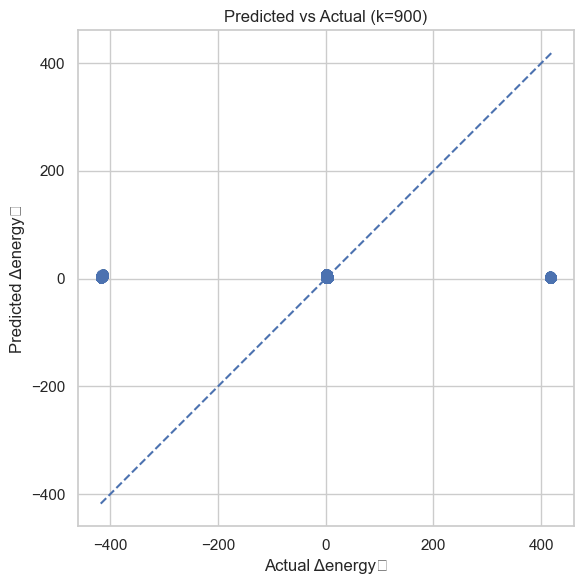

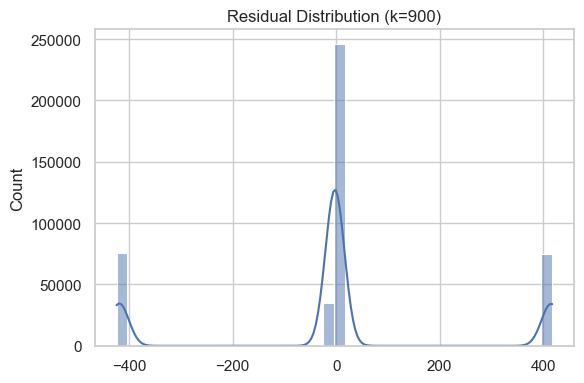

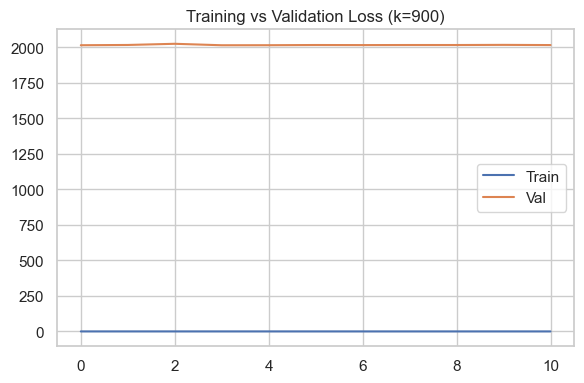

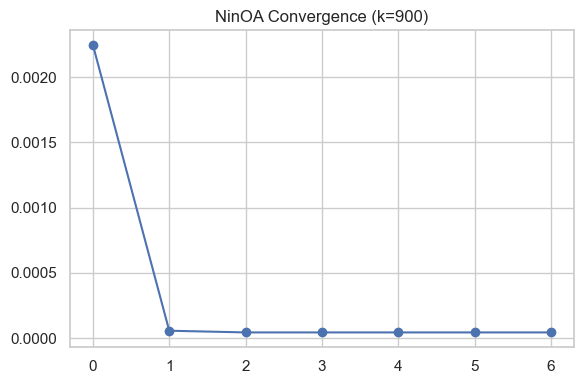

Completed k=900


In [16]:
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()],
             [y_true.min(), y_true.max()],
             linestyle="--")
    plt.xlabel("Actual Δenergyₖ")
    plt.ylabel("Predicted Δenergyₖ")
    plt.title(f"Predicted vs Actual (k={k})")
    plt.tight_layout()
    plt.show()

    residuals = y_true - y_pred
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, bins=40, kde=True)
    plt.title(f"Residual Distribution (k={k})")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(history.history["loss"], label="Train")
    plt.plot(history.history["val_loss"], label="Val")
    plt.legend()
    plt.title(f"Training vs Validation Loss (k={k})")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(convergence, marker="o")
    plt.title(f"NinOA Convergence (k={k})")
    plt.tight_layout()
    plt.show()

    print(f"Completed k={k}")
